# Semantic Segmentation

In this project we will train a UNet model to perform semantic segmentation of people contained in the pictures of the <a href="https://www.cis.upenn.edu/~jshi/ped_html/">PennFudanPed dataset</a>. This dataset contains pictures of people walking, and the relative masks:

<center><img src="notebook_ims/segmentation.png" width="70%"></center>

Each person in the picture corresponds to a certain value in the mask. However, in this exercise we are interested in _semantic_ segmentation and not _instance_ segmentation, so we will consider all people as part of the same class. This means that we have two classes: people, and background (i.e., it is a binary segmentation):

<center><img src="notebook_ims/semantic_segmentation.png" width="70%"></center>

In [1]:
!pip install -r requirements.txt

> Wait for the previous cell to complete, then restart the kernel before running the next cell. This ensures that the dependencies we have just installed will work. Of course, the second time DO NOT rerun the previous cell, but start from the next one

## Setting Up

Let's import a bunch of modules that we will need in the notebook. We also initialize the random number generators belonging to a few different packages to ensure repeatibility:

In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from helpers import PennFudanDataset
from helpers import get_data_loaders
import matplotlib.pyplot as plt
from torch import nn
import torch
import segmentation_models_pytorch as smp
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import random
import metrics
import numpy as np
import cv2

# Seed random generator for repeatibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


/home/pc/anaconda3/envs/deep-learning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Transforms for Semantic Segmentation


In [2]:
# The input of a UNET with 5 downsampling operations
# needs to be divisible by 2**5 = 32 in both width
# and height. For simplicity we use square images
SIZE = 448

train_transforms = A.Compose(
    [
        # We first pad to make sure we have a dimension of
        # at least SIZE x SIZE. If padding is needed (because an image is
        # smaller than SIZE x SIZE), then a constant padding with green color
        # is added
        A.PadIfNeeded(SIZE, SIZE, border_mode=0, value=(0, 255, 0)),
        # Augmentations
        # We use a random crop instead of a center crop so each time the network
        # will see a different image
        A.RandomCrop(SIZE, SIZE),
        # Other augmentations. See the manual of the Albumentations package for
        # an explanation of what each one of these do
        A.HorizontalFlip(),
        A.OneOf(
            [
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=0.1),
                A.PiecewiseAffine(p=0.3),
            ],
            p=0.3,
        ),
        A.OneOf(
            [
                A.HueSaturationValue(10, 15, 10),
                A.CLAHE(clip_limit=2),
                A.RandomBrightnessContrast(),
            ],
            p=0.3,
        ),
        # Normalization
        A.Normalize(PennFudanDataset.mean, PennFudanDataset.std),
        ToTensorV2(),
    ]
)

valid_transforms = A.Compose(
    [
        A.PadIfNeeded(SIZE, SIZE, border_mode=0, value=(0, 255, 0)),
        A.CenterCrop(SIZE, SIZE),
        A.Normalize(PennFudanDataset.mean, PennFudanDataset.std),
        ToTensorV2(),
    ]
)

We can  now get the data loaders. Since this is mostly boilerplate code, we have saved you the trouble and provide a function for this in `helpers.py`. Please refer to the code if you are curious to see how this is accomplished.

In [3]:
dl = get_data_loaders(
    "PennFudanPed", train_transforms, valid_transforms, num_workers=-1, batch_size=4
)

## Define the Model
We are going to use a UNet architecture:

<center><img src="notebook_ims/unet.png" width="50%"></center>

We use [efficientnet-b2](https://paperswithcode.com/method/efficientnet) as backbone, pre-trained on ImageNet:

In [4]:
model = smp.Unet(
        encoder_name='efficientnet-b2',
        encoder_weights='imagenet',
        in_channels=3,
        # Binary classification
        classes=1
    )

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /home/pc/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████████████████████████████████| 35.1M/35.1M [00:04<00:00, 7.73MB/s]


## Training


In [5]:
loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-1},
    {'params': model.encoder.parameters(), 'lr': 1e-3},
])

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def train_one_epoch(epoch, model, data_loaders, optimizer, loss_function):
    # Set the model to train mode
    model.train()
    
    # Move to the GPU if available
    model.to(DEVICE)
    
    # Training loop
    train_loss = 0
    
    for i, (imgs, masks) in tqdm(
        enumerate(data_loaders["train"]), total=len(data_loaders["train"]), ncols=60
    ):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Move images and masks to the GPU (if available)
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        
        # Execute a forward pass
        outputs = model(imgs)
        # Compute loss
        loss = loss_function(outputs, masks)
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        train_loss += loss.item()
    
    # Compute average loss for this epoch
    train_loss /= len(data_loaders["train"])

    # Validate
    # Put the model in evaluation state
    model.eval()
    
    # Loop and accumulate the validation loss, as well as the 
    # True Positives, False Positives, False Negatives, True Negatives.
    # We will use these to compute the Intersection over Union metric
    # at the end of the validation phase
    valid_loss = 0

    tp, fp, fn, tn = [0] * 4

    with torch.no_grad():
        for i, (imgs, masks) in tqdm(
            enumerate(data_loaders["valid"]), total=len(data_loaders["valid"]), ncols=60
        ):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(imgs)
            loss = loss_function(outputs, masks)
            valid_loss += loss.item()

            # Compute statistics for true positives, false positives, false negative and
            # true negative "pixels"
            this_tp, this_fp, this_fn, this_tn = metrics.get_stats(
                outputs.squeeze(), masks.squeeze(), mode="binary", threshold=0.5
            )

            tp += this_tp
            fp += this_fp
            fn += this_fn
            tn += this_tn

    # compute Intersection Over Union
    iou_score = metrics.iou_score(sum(tp), sum(fp), sum(fn), sum(tn), reduction="micro")

    valid_loss /= len(data_loaders["valid"])

    return train_loss, valid_loss, iou_score

In [7]:
# Reduce the learning rate by a factor of 10 every 30 epochs
scheduler = StepLR(optimizer, step_size=30, gamma=0.1, verbose=False)

# Train for a few epochs, printing the progress along the way
for epoch in range(50):
    
    train_loss, valid_loss, iou = train_one_epoch(epoch, model, dl, optimizer, loss)
    print(f"EPOCH: {epoch + 1} - train loss: {train_loss} -  valid_loss: {valid_loss} - IoU: {iou:.3f}")
    
    scheduler.step()

100%|███████████████████████| 34/34 [00:00<00:00, 49.65it/s]

EPOCH: 1 - train loss: 0.4919566249146181 -  valid_loss: 0.21024181562311509 - IoU: 0.695



100%|███████████████████████| 34/34 [00:00<00:00, 85.19it/s]


EPOCH: 2 - train loss: 0.191811344202827 -  valid_loss: 0.1555850418174968 - IoU: 0.749


100%|███████████████████████| 34/34 [00:00<00:00, 82.66it/s]


EPOCH: 3 - train loss: 0.14601677831481485 -  valid_loss: 0.16149412709123948 - IoU: 0.728


100%|███████████████████████| 34/34 [00:00<00:00, 83.38it/s]

EPOCH: 4 - train loss: 0.1314518030952005 -  valid_loss: 0.1364322725464316 - IoU: 0.755



100%|███████████████████████| 34/34 [00:00<00:00, 86.50it/s]

EPOCH: 5 - train loss: 0.11459587426746592 -  valid_loss: 0.19052679223172805 - IoU: 0.698



100%|███████████████████████| 34/34 [00:00<00:00, 85.23it/s]


EPOCH: 6 - train loss: 0.11202683869530172 -  valid_loss: 0.09784733197268318 - IoU: 0.830


100%|███████████████████████| 34/34 [00:00<00:00, 84.09it/s]

EPOCH: 7 - train loss: 0.10038540468496435 -  valid_loss: 0.11927188144010656 - IoU: 0.796



100%|███████████████████████| 34/34 [00:00<00:00, 84.02it/s]


EPOCH: 8 - train loss: 0.09564115194713368 -  valid_loss: 0.11837496477014878 - IoU: 0.793


100%|███████████████████████| 34/34 [00:00<00:00, 86.76it/s]

EPOCH: 9 - train loss: 0.09195124927689047 -  valid_loss: 0.10195488614194534 - IoU: 0.818



100%|███████████████████████| 34/34 [00:00<00:00, 82.59it/s]


EPOCH: 10 - train loss: 0.09211119483498965 -  valid_loss: 0.09857272926498861 - IoU: 0.821


100%|███████████████████████| 34/34 [00:00<00:00, 84.05it/s]


EPOCH: 11 - train loss: 0.10639529017841115 -  valid_loss: 0.08580176269306856 - IoU: 0.846


100%|███████████████████████| 34/34 [00:00<00:00, 80.72it/s]

EPOCH: 12 - train loss: 0.10215207233148463 -  valid_loss: 0.11542083936579087 - IoU: 0.803



100%|███████████████████████| 34/34 [00:00<00:00, 80.56it/s]

EPOCH: 13 - train loss: 0.09195133693077985 -  valid_loss: 0.08287419291103587 - IoU: 0.853



100%|███████████████████████| 34/34 [00:00<00:00, 85.45it/s]

EPOCH: 14 - train loss: 0.07594054060823777 -  valid_loss: 0.08377344818676219 - IoU: 0.851



100%|███████████████████████| 34/34 [00:00<00:00, 81.75it/s]

EPOCH: 15 - train loss: 0.07329341769218445 -  valid_loss: 0.0799753157531514 - IoU: 0.859



100%|███████████████████████| 34/34 [00:00<00:00, 84.71it/s]


EPOCH: 16 - train loss: 0.06529925851260915 -  valid_loss: 0.0773630860973807 - IoU: 0.864


100%|███████████████████████| 34/34 [00:00<00:00, 82.94it/s]

EPOCH: 17 - train loss: 0.0659180248484892 -  valid_loss: 0.08043104410171509 - IoU: 0.852



100%|███████████████████████| 34/34 [00:00<00:00, 85.84it/s]

EPOCH: 18 - train loss: 0.06571623682975769 -  valid_loss: 0.07690887416110319 - IoU: 0.866



100%|███████████████████████| 34/34 [00:00<00:00, 82.14it/s]

EPOCH: 19 - train loss: 0.06929858642465928 -  valid_loss: 0.08536762174438028 - IoU: 0.844



100%|███████████████████████| 34/34 [00:00<00:00, 81.55it/s]

EPOCH: 20 - train loss: 0.06965736957157359 -  valid_loss: 0.0793266243794385 - IoU: 0.855



100%|███████████████████████| 34/34 [00:00<00:00, 82.23it/s]

EPOCH: 21 - train loss: 0.06930263603434843 -  valid_loss: 0.08081053109729991 - IoU: 0.854



100%|███████████████████████| 34/34 [00:00<00:00, 80.62it/s]

EPOCH: 22 - train loss: 0.05951678577591391 -  valid_loss: 0.0828761125312132 - IoU: 0.849



100%|███████████████████████| 34/34 [00:00<00:00, 84.17it/s]

EPOCH: 23 - train loss: 0.06249298944192774 -  valid_loss: 0.0869834352942074 - IoU: 0.843



100%|███████████████████████| 34/34 [00:00<00:00, 82.17it/s]

EPOCH: 24 - train loss: 0.059092123718822706 -  valid_loss: 0.07859357490259058 - IoU: 0.859



100%|███████████████████████| 34/34 [00:00<00:00, 85.23it/s]


EPOCH: 25 - train loss: 0.060470600338543165 -  valid_loss: 0.07665264255860273 - IoU: 0.864


100%|███████████████████████| 34/34 [00:00<00:00, 85.92it/s]

EPOCH: 26 - train loss: 0.058846736655515784 -  valid_loss: 0.07555985976667966 - IoU: 0.866



100%|███████████████████████| 34/34 [00:00<00:00, 82.61it/s]

EPOCH: 27 - train loss: 0.05407225209123948 -  valid_loss: 0.08391889403848087 - IoU: 0.848



100%|███████████████████████| 34/34 [00:00<00:00, 86.51it/s]

EPOCH: 28 - train loss: 0.05586807868059944 -  valid_loss: 0.12019485585829791 - IoU: 0.802



100%|███████████████████████| 34/34 [00:00<00:00, 83.44it/s]


EPOCH: 29 - train loss: 0.06399867815129898 -  valid_loss: 0.0763606937492595 - IoU: 0.864


100%|███████████████████████| 34/34 [00:00<00:00, 85.50it/s]


EPOCH: 30 - train loss: 0.05962979267625248 -  valid_loss: 0.08533635034280665 - IoU: 0.843


100%|███████████████████████| 34/34 [00:00<00:00, 84.11it/s]


EPOCH: 31 - train loss: 0.05344293573323418 -  valid_loss: 0.07691901220994837 - IoU: 0.859


100%|███████████████████████| 34/34 [00:00<00:00, 81.31it/s]

EPOCH: 32 - train loss: 0.04787078675101785 -  valid_loss: 0.07245023460949168 - IoU: 0.868



100%|███████████████████████| 34/34 [00:00<00:00, 84.12it/s]


EPOCH: 33 - train loss: 0.04606176825130687 -  valid_loss: 0.07012774663812973 - IoU: 0.872


100%|███████████████████████| 34/34 [00:00<00:00, 83.10it/s]


EPOCH: 34 - train loss: 0.04527925393160652 -  valid_loss: 0.06839330582057729 - IoU: 0.875


100%|███████████████████████| 34/34 [00:00<00:00, 82.16it/s]


EPOCH: 35 - train loss: 0.04478569416438832 -  valid_loss: 0.06803502756006577 - IoU: 0.876


100%|███████████████████████| 34/34 [00:00<00:00, 84.42it/s]


EPOCH: 36 - train loss: 0.045622317230000216 -  valid_loss: 0.0677381859106176 - IoU: 0.877


100%|███████████████████████| 34/34 [00:00<00:00, 83.25it/s]


EPOCH: 37 - train loss: 0.04509134152356316 -  valid_loss: 0.06734003214275136 - IoU: 0.878


100%|███████████████████████| 34/34 [00:00<00:00, 83.25it/s]


EPOCH: 38 - train loss: 0.04179119011935066 -  valid_loss: 0.06735999093336217 - IoU: 0.878


100%|███████████████████████| 34/34 [00:00<00:00, 80.72it/s]

EPOCH: 39 - train loss: 0.04449214830118067 -  valid_loss: 0.06705584596185123 - IoU: 0.878



100%|███████████████████████| 34/34 [00:00<00:00, 83.06it/s]

EPOCH: 40 - train loss: 0.042608734439401066 -  valid_loss: 0.06671946364290574 - IoU: 0.879



100%|███████████████████████| 34/34 [00:00<00:00, 82.07it/s]


EPOCH: 41 - train loss: 0.04241243706030004 -  valid_loss: 0.06696105879895828 - IoU: 0.878


100%|███████████████████████| 34/34 [00:00<00:00, 79.74it/s]

EPOCH: 42 - train loss: 0.044616865761139816 -  valid_loss: 0.06731079606448903 - IoU: 0.878



100%|███████████████████████| 34/34 [00:00<00:00, 83.08it/s]


EPOCH: 43 - train loss: 0.04235516400898204 -  valid_loss: 0.06608926548677332 - IoU: 0.880


100%|███████████████████████| 34/34 [00:00<00:00, 81.74it/s]

EPOCH: 44 - train loss: 0.04091427080771502 -  valid_loss: 0.06617114649099462 - IoU: 0.880



100%|███████████████████████| 34/34 [00:00<00:00, 84.66it/s]


EPOCH: 45 - train loss: 0.042314613566679114 -  valid_loss: 0.06613058553022497 - IoU: 0.880


100%|███████████████████████| 34/34 [00:00<00:00, 82.14it/s]

EPOCH: 46 - train loss: 0.04335890798007741 -  valid_loss: 0.06581915476742912 - IoU: 0.881



100%|███████████████████████| 34/34 [00:00<00:00, 80.95it/s]

EPOCH: 47 - train loss: 0.04126023369676927 -  valid_loss: 0.06428364094565897 - IoU: 0.884



100%|███████████████████████| 34/34 [00:00<00:00, 83.70it/s]


EPOCH: 48 - train loss: 0.0414101498968461 -  valid_loss: 0.06385116542086881 - IoU: 0.885


100%|███████████████████████| 34/34 [00:00<00:00, 82.78it/s]

EPOCH: 49 - train loss: 0.0436903904466068 -  valid_loss: 0.06347754772971659 - IoU: 0.886



100%|███████████████████████| 34/34 [00:00<00:00, 84.74it/s]


EPOCH: 50 - train loss: 0.04004531748154584 -  valid_loss: 0.06327435374259949 - IoU: 0.885


## Results


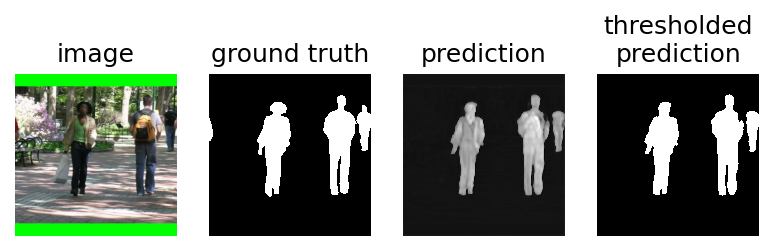

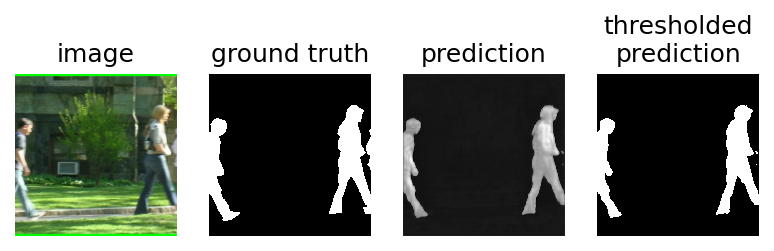

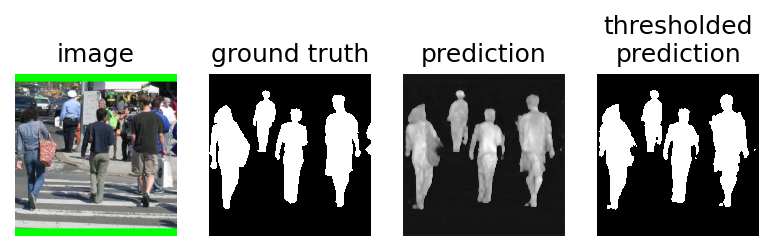

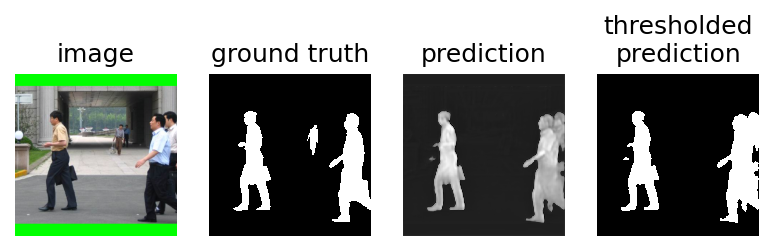

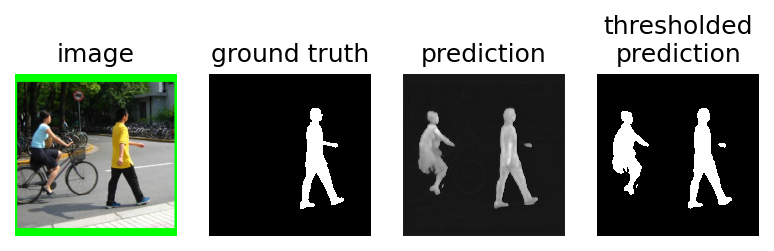

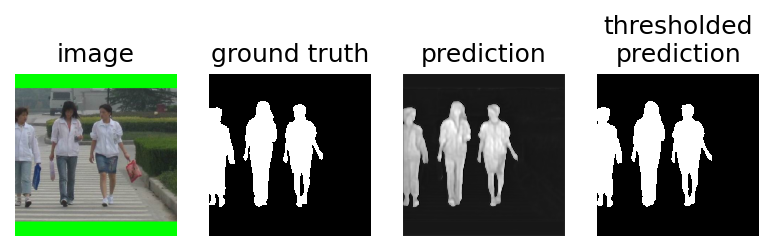

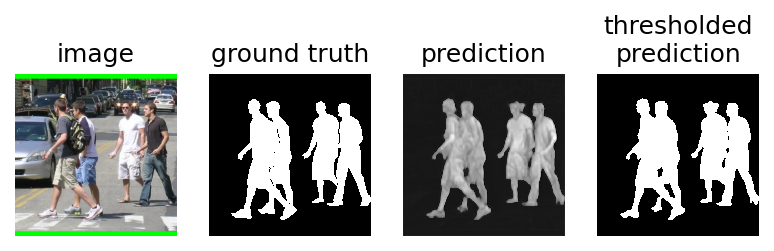

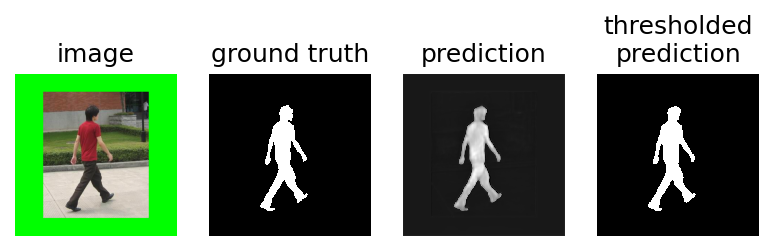

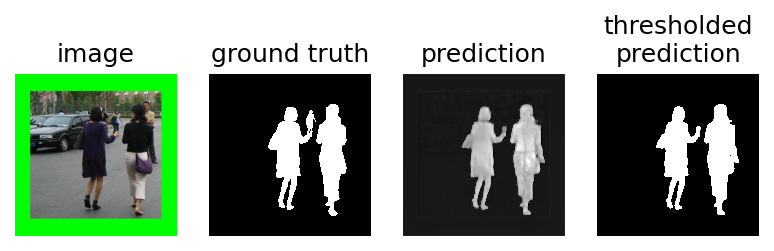

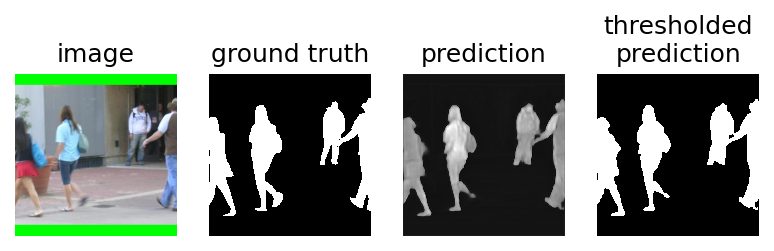

In [8]:
import torchvision.transforms as T
import numpy as np

def plot_some_results(n=10):
    
    valid_it = iter(dl['valid'])
    
    for _ in range(n):

        image, gt_mask = next(valid_it)
        with torch.no_grad():
            pred = model(image.cuda())[0]

        # Invert the T.Normalize transform
        unnormalize = T.Compose(
            [
                T.ToTensor(),
                T.Normalize(mean = [ 0., 0., 0. ], std = 1 / PennFudanDataset.std),
                T.Normalize(mean = -PennFudanDataset.mean, std = [ 1., 1., 1. ])
            ]
        )

        image = (unnormalize(image.squeeze().numpy().T) * 255).numpy().astype(np.uint8)

        fig, ax = plt.subplots(1, 4, dpi=150)

        _ = ax[0].imshow(image.T)
        _ = ax[1].imshow(gt_mask.squeeze() * 255, cmap='gray', interpolation='none')
        _ = ax[2].imshow(pred.cpu().squeeze(), cmap='gray', interpolation='none')
        _ = ax[3].imshow((pred.cpu().squeeze() > 0) * 255, cmap='gray', interpolation='none')

        _ = [sub.axis("off") for sub in ax.flatten()]
        ax[0].set_title("image")
        ax[1].set_title("ground truth")
        ax[2].set_title("prediction")
        ax[3].set_title("thresholded\nprediction")

plot_some_results()

In general, our model seems to perform very well given how little data it has seen. It's not perfect though. We can also see that sometimes the ground truth itself is imprecise and sometimes our model is actually better than the ground truth.
